In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)
from datetime import date, timedelta
from scipy import stats
import scipy.optimize as sco
import random
import warnings
warnings.filterwarnings("ignore")

In [2]:
symbol = pd.read_csv("nasdaq_stocks.csv")
symbol_dict = dict(zip(symbol["Name"], symbol["Symbol"]))
#stocks = ["Apple Inc.", "Amazon.com Inc.", "Alphabet Inc.", "Netflix Inc.", "Tesla Inc."]
stocks = random.sample(list(symbol_dict.keys()), 10)
stocks = [symbol_dict[i] for i in stocks]

In [3]:
stocks = ['ALRS', 'DKL', 'KRNT', 'MTH', 'MYD', 'POOL', 'RSG']
stocks

['ALRS', 'DKL', 'KRNT', 'MTH', 'MYD', 'POOL', 'RSG']

In [4]:
data = pdr.get_data_yahoo(stocks, start=date.today()-timedelta(365*6), end=date.today()-timedelta(365))["Adj Close"]

[*********************100%***********************]  7 of 7 completed


In [5]:
list(set(data.columns) - set(data.dropna(axis=1).columns))

[]

In [6]:
data = data.dropna(axis=1)

In [7]:
data

,ALRS,DKL,KRNT,MTH,MYD,POOL,RSG
Date,,,,,,,
2016-01-19,15.411111,14.550030,10.490000,27.389999,10.927785,70.404472,38.878365
2016-01-20,15.281966,13.415271,10.510000,27.190001,10.883812,69.954056,37.909737
2016-01-21,15.540254,13.011558,10.450000,26.860001,10.949774,69.785164,37.500950
2016-01-22,15.540254,13.393448,11.270000,28.120001,10.957105,71.502319,38.149673
2016-01-25,15.454163,13.278882,11.370000,27.170000,10.957105,73.163216,37.687569
...,...,...,...,...,...,...,...
2021-01-08,28.851458,31.287571,89.059998,80.160004,13.573341,388.356842,95.506195
2021-01-11,29.115883,31.672029,88.150002,81.830002,13.497140,382.655487,94.304604
2021-01-12,29.899357,32.523327,90.699997,83.019997,13.535240,382.407166,93.812149


In [8]:
def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights)*252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))*np.sqrt(252)
    return std, returns

def neg_prob_sharpe_ratio(weights, mean_returns, log_returns, cov_matrix, risk_free_rate, sharpe_ratio_benchmark):
    p_var, p_ret = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
    sharpe_ratio = (p_ret - risk_free_rate)/p_var
    coskew = pd.Series(stats.skew(mean_returns), index=mean_returns.index).mean()
    cokurt = pd.Series(stats.kurtosis(mean_returns, fisher=False), index=mean_returns.index).mean()    
    sharpe_ratio_stdev = np.sqrt((1+(0.5*sharpe_ratio**2) - coskew*sharpe_ratio) + (((cokurt-3)/4)*sharpe_ratio**2))/(len(mean_returns)-1)
    prob_sharpe_ratio = stats.norm.cdf((sharpe_ratio - sharpe_ratio_benchmark)/sharpe_ratio_stdev)
    return -1*prob_sharpe_ratio

def max_sharpe_ratio(mean_returns, log_returns, cov_matrix, risk_free_rate, sharpe_ratio_benchmark=0.0):
    num_assets = len(mean_returns)
    args = (mean_returns, log_returns, cov_matrix, risk_free_rate, sharpe_ratio_benchmark)
    constraints = ({"type": "eq", "fun": lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_prob_sharpe_ratio, num_assets*[1./num_assets,], args=args, method="SLSQP", bounds=bounds, constraints=constraints)
    return result

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualized_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({"type": "eq", "fun": lambda x: np.sum(x) - 1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method="SLSQP", bounds=bounds, constraints=constraints)
    return result

def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualized_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({"type": "eq", "fun": lambda x: portfolio_return(x) - target}, {"type": "eq", "fun": lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method="SLSQP", bounds=bounds, constraints=constraints)
    return result

def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [9]:
returns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
risk_free_rate = 0.0178
log_returns = np.log(data/data.shift(1))
log_returns = log_returns.dropna()

In [10]:
max_sharpe = max_sharpe_ratio(mean_returns, log_returns, cov_matrix, risk_free_rate, sharpe_ratio_benchmark=1.0)
sdp, rp = portfolio_annualized_performance(max_sharpe["x"], mean_returns, cov_matrix)
max_sharpe_allocation = pd.DataFrame(max_sharpe["x"], index=data.columns, columns=["allocation"])
max_sharpe_allocation["allocation"] = [round(i*100, 2)for i in max_sharpe_allocation["allocation"]]
max_sharpe_allocation = max_sharpe_allocation.T

min_vol = min_variance(mean_returns, cov_matrix)
sdp_min, rp_min = portfolio_annualized_performance(min_vol["x"], mean_returns, cov_matrix)
min_vol_allocation = pd.DataFrame(min_vol.x,index=data.columns,columns=["allocation"])
min_vol_allocation["allocation"] = [round(i*100,2)for i in min_vol_allocation["allocation"]]
min_vol_allocation = min_vol_allocation.T

an_vol = np.std(returns)*np.sqrt(252)
an_rt = mean_returns*252

In [11]:
print("\nMaximum Sharpe Ratio Portfolio Allocation")
print("Annualized Return:", round(rp, 2))
print("Annualized Volatility:", round(sdp, 2))
print(max_sharpe_allocation)

print("\nMinimum Volatility Portfolio Allocation")
print("Annualized Return:", round(rp_min, 2))
print("Annualized Volatility:", round(sdp_min, 2))
print(min_vol_allocation)

print("\nIndividual Stock Returns and Volatility")
for i, txt in enumerate(data.columns):
    print("{}: Annualized Return: {}; Annualized Volatility: {}".format(txt, round(an_rt[i], 2), round(an_vol[i], 2)))


Maximum Sharpe Ratio Portfolio Allocation
Annualized Return: 0.36
Annualized Volatility: 0.23
            ALRS   DKL  KRNT  MTH  MYD   POOL    RSG
allocation  13.6  3.08  22.0  0.0  0.0  48.96  12.35

Minimum Volatility Portfolio Allocation
Annualized Return: 0.11
Annualized Volatility: 0.12
             ALRS  DKL  KRNT  MTH    MYD  POOL   RSG
allocation  19.17  0.0   0.0  0.0  63.76  8.21  8.86

Individual Stock Returns and Volatility
ALRS: Annualized Return: 0.16; Annualized Volatility: 0.25
DKL: Annualized Return: 0.31; Annualized Volatility: 0.55
KRNT: Annualized Return: 0.57; Annualized Volatility: 0.51
MTH: Annualized Return: 0.33; Annualized Volatility: 0.46
MYD: Annualized Return: 0.05; Annualized Volatility: 0.15
POOL: Annualized Return: 0.37; Annualized Volatility: 0.28
RSG: Annualized Return: 0.19; Annualized Volatility: 0.2


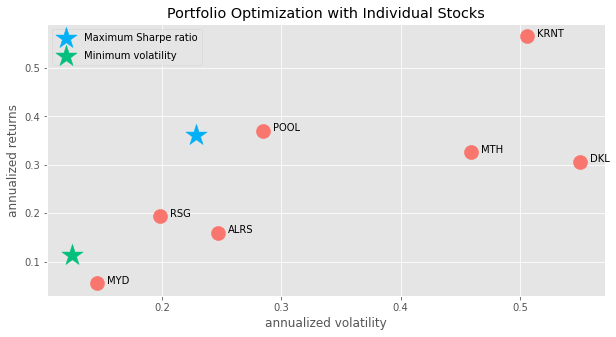

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(an_vol, an_rt, marker="o", color="#f8766d", s=200)

for i, txt in enumerate(data.columns):
    ax.annotate(txt, (an_vol[i], an_rt[i]), xytext=(10, 0), textcoords="offset points")

ax.scatter(sdp, rp, marker="*", color="#01b0f6", s=500, label="Maximum Sharpe ratio")
ax.scatter(sdp_min, rp_min, marker="*", color="#02bf7d", s=500, label="Minimum volatility")

#target = np.linspace(rp_min, 0.34, 50)
#efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)

#ax.plot([pf["fun"] for pf in efficient_portfolios], target, linestyle="-.", color="black", label="efficient frontier")
ax.set_title("Portfolio Optimization with Individual Stocks")
ax.set_xlabel("annualized volatility")
ax.set_ylabel("annualized returns")
ax.legend(labelspacing=0.8)
plt.show(fig)

In [13]:
df_test = pdr.get_data_yahoo(list(data.columns), start=date.today()-timedelta(365))["Adj Close"]

[*********************100%***********************]  7 of 7 completed


In [14]:
ret_sharpe = 0
for i in df_test.columns:
    ret_sharpe += df_test[i]*max_sharpe_allocation.reset_index(drop=True)[i][0]
ret_sharpe /= 100

ret_vol = 0
for i in df_test.columns:
    ret_vol += df_test[i]*min_vol_allocation.reset_index(drop=True)[i][0]
ret_vol /= 100

In [15]:
df_test = pdr.get_data_yahoo(list(data.columns), start=date.today()-timedelta(365))["Adj Close"]

[*********************100%***********************]  7 of 7 completed


In [16]:
df_test["MSP"] = ret_sharpe
df_test["MVP"] = ret_vol

In [17]:
if df_test.isna().sum().sum() > 0:
    df_test = df_test.dropna()

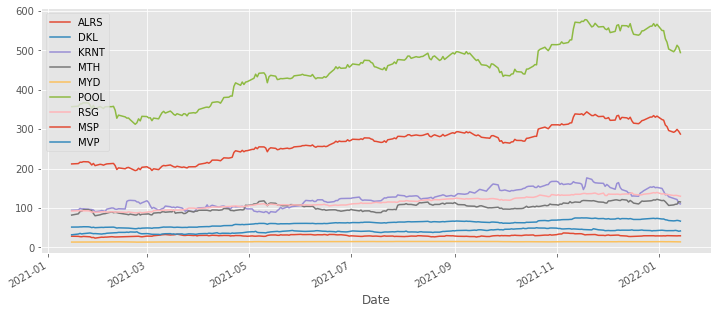

In [18]:
df_test.plot(figsize=(12,5),legend=True)
plt.show()

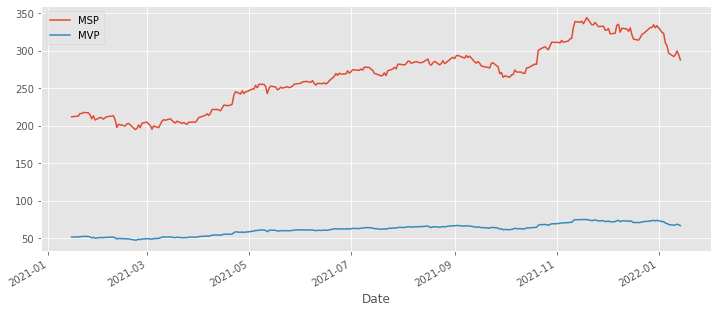

In [19]:
df_test[["MSP", "MVP"]].plot(figsize=(12,5),legend=True)
plt.show()

In [20]:
(df_test["MSP"][-1] - df_test["MSP"][0])/df_test["MSP"][0] * 100

35.77463211129522

In [21]:
(df_test["MVP"][-1] - df_test["MVP"][0])/df_test["MVP"][0] * 100

29.313860548759767

In [22]:
df_test

,ALRS,DKL,KRNT,MTH,MYD,POOL,RSG,MSP,MVP
Date,,,,,,,,,
2021-01-15,28.410755,32.038177,94.260002,82.029999,13.559956,356.979553,92.393890,211.775688,51.586290
2021-01-19,28.077780,33.951317,94.889999,85.190002,13.588641,358.201324,93.240906,212.630669,51.716097
2021-01-20,27.264921,35.571533,98.959999,91.099998,13.674706,363.773499,93.250763,216.194808,52.073500
2021-01-21,27.118023,34.125233,97.500000,91.860001,13.770333,364.240326,92.551483,215.951295,52.082684
2021-01-22,27.891701,34.949078,97.949997,95.290001,13.732080,366.822845,92.974991,217.497579,52.456155
...,...,...,...,...,...,...,...,...,...
2022-01-10,29.500000,42.540001,124.440002,107.790001,14.495551,496.309998,131.630005,291.948713,67.306983
2022-01-11,29.450001,43.240002,122.790001,109.430000,14.376000,502.059998,132.100006,294.473718,67.734889
2022-01-12,29.270000,42.500000,121.459999,109.709999,14.376000,512.809998,131.820007,299.362466,68.558150
